In [1]:
# Import helper libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
from io import BytesIO # Use When expecting bytes-like objects
import pickle
from collections import OrderedDict
import os
from os import path
import ast
import random

# import matplotlib for visualization
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

# import PIL for image manipulation
from PIL import Image, ImageDraw, ImageOps

# import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# import pytorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

![header image](https://github.com/Lexie88rus/quick-draw-image-recognition/blob/master/app/static/jumbotron.png?raw=true)

# Getting Started with Deep Learning and PyTorch for Quick, Draw! Doodles Recognition

## DEFINITION

### Overview
The [Quick Draw](https://github.com/googlecreativelab/quickdraw-dataset) Dataset is a collection of 50 million drawings across 345 categories, contributed by players of the game [Quick, Draw!](https://quickdraw.withgoogle.com/). The player starts with an object to draw (for example it may say "Draw a chair in under 20 seconds"). Then the player has twenty seconds to draw that object. Based on what they draw, the AI guesses what they are drawing.
Research in recognition of images drawn by humans can improve pattern recognition solutions more broadly. Improving pattern recognition has an impact on handwriting recognition and its robust applications in areas including OCR (Optical Character Recognition), ASR (Automatic Speech Recognition) & NLP (Natural Language Processing).
__In this kernel I analyzed the drawings and tried to build a deep learning application to classify those drawings__ (in this [GitHub repository](https://github.com/Lexie88rus/quick-draw-image-recognition) you can find the code for the resulting web application to play around with the model).

### Problem Statement

Recognition of a drawing is a classification problem. I have to build a solution, which classifies input images. I split the whole problem of recognition of drawings into the following tasks:
* Input data analysis and preprocessing;
* Building a model to classify drawings;
* Evaluation of the model concerning chosen metrics;
* Building a web-application to demonstrate the results.

I am new to deep learning, so I simplified this task to only ten classes from the dataset. I will also shrink the input images to 28x28 pixels in order to be able to use simple fully connected network to classify the images.

### Metrics

I chose accuracy as a metric to evaluate the results. Because of the rules of the game, we mostly care about how many times did the AI recognize the drawing correctly, and this is just the accuracy of the model.

## INPUT DATA

### Load Data

I am going to load the simplified data for 10 classes:

In [2]:
# define 10 classes to load the data for
categories = ['cannon','eye', 'face', 'nail', 'pear','piano','radio','spider','star','sword']
label_dict = {0:'cannon',1:'eye', 2:'face', 3:'nail', 4:'pear',
                      5:'piano',6:'radio', 7:'spider', 8:'star', 9:'sword'}

# load data for each category
classes = {}
for category in categories:
    data = pd.read_csv("../input/train_simplified/" + category + ".csv")
    classes[category] = data

### Explore and Preprocess Data

I want to work with a simplified representation of images. I will shrink initial images to 28x28 grayscale images. For image manipulation I am going to use utility functions described below. 

In [3]:
# Image manipulation utilities: 

def convert_to_PIL(drawing, width = 256, height = 256):
    """
    Function to convert from drawing to PIL image.
    INPUT:
        drawing - drawing from 'drawing' column
        width - width of the initial image
        height - height of the initial image
    OUTPUT:
        pil_img - (PIL Image) image
    """
    
    # initialize empty (white) PIL image
    pil_img = Image.new('RGB', (width, height), 'white')
    pixels = pil_img.load()
            
    draw = ImageDraw.Draw(pil_img)
    
    # draw strokes as lines
    for x,y in drawing:
        for i in range(1, len(x)):
            draw.line((x[i-1], y[i-1], x[i], y[i]), fill=0)
        
    return pil_img

def convert_to_np_raw(drawing, width = 256, height = 256):
    """
    INPUT:
        drawing - drawing in initial format
        width - width of the initial image
        height - height of the initial image
    OUTPUT:
        img - drawing converted to the numpy array (28 X 28)
    """
    # initialize empty numpy array
    img = np.zeros((28, 28))
    
    # create a PIL image out of drawing
    pil_img = convert_to_PIL(drawing)
    
    #resize to 28,28
    pil_img.thumbnail((28,28), Image.ANTIALIAS)
    
    pil_img = pil_img.convert('RGB')
    pixels = pil_img.load()
    
    # fill in numpy array with pixel values
    for i in range(0, 28):
        for j in range(0, 28):
            img[i, j] = 1 - pixels[j, i][0] / 255
    
    return img

def convert_to_np(pil_img, width = 256, height = 256):
    """
    Function to convert PIL Image to numpy array.
    INPUT:
        pil_img - (PIL Image) image to be converted
    OUTPUT:
        img - (numpy array) converted image with shape (width, height)
    """
    pil_img = pil_img.convert('RGB')

    img = np.zeros((width, height))
    pixels = pil_img.load()

    for i in range(0, width):
        for j in range(0, height):
            img[i, j] = 1 - pixels[j, i][0] / 255

    return img

def view_image(img, width = 256, height = 256):
    """
    Function to view numpy image with matplotlib.
    The function saves the image as png.
    INPUT:
        img - (numpy array) image from train dataset with size (1, 784)
    OUTPUT:
        None
    """
    fig, ax = plt.subplots(figsize=(6,9))
    ax.imshow(img.reshape(width, height).squeeze())
    ax.axis('off')

    plt.show()
    
def crop_image(image):
    """
    Crops image (crops out white spaces).
    INPUT:
        image - PIL image of original size to be cropped
    OUTPUT:
        cropped_image - PIL image cropped to the center  and resized to (28, 28)
    """
    cropped_image = image

    # get image size
    width, height = cropped_image.size

    # get image pixels
    pixels = cropped_image.load()

    image_strokes_rows = []
    image_strokes_cols = []

    # run through the image
    for i in range(0, width):
        for j in range(0, height):
            # save coordinates of the image
            if (pixels[i,j][0] > 0):
                image_strokes_cols.append(i)
                image_strokes_rows.append(j)

    # if image is not empty then crop to contents of the image
    if (len(image_strokes_rows)) > 0:
        # find the box for image
        row_min = np.array(image_strokes_rows).min()
        row_max = np.array(image_strokes_rows).max()
        col_min = np.array(image_strokes_cols).min()
        col_max = np.array(image_strokes_cols).max()

        # find the box for cropping
        margin = min(row_min, height - row_max, col_min, width - col_max)

        # crop image
        border = (col_min, row_min, width - col_max, height - row_max)
        cropped_image = ImageOps.crop(cropped_image, border)

    # get cropped image size
    width_cropped, height_cropped = cropped_image.size

    # create square resulting image to paste cropped image into the center
    dst_im = Image.new("RGBA", (max(width_cropped, height_cropped), max(width_cropped, height_cropped)), "white")
    offset = ((max(width_cropped, height_cropped) - width_cropped) // 2, (max(width_cropped, height_cropped) - height_cropped) // 2)
    # paste to the center of a resulting image
    dst_im.paste(cropped_image, offset)

    #resize to 28,28
    dst_im.thumbnail((28,28), Image.ANTIALIAS)

    return dst_im

def normalize(arr):
    """
    Function performs the linear normalizarion of the array.
    https://stackoverflow.com/questions/7422204/intensity-normalization-of-image-using-pythonpil-speed-issues
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    INPUT:
        arr - orginal numpy array
    OUTPUT:
        arr - normalized numpy array
    """
    arr = arr.astype('float')
    # Do not touch the alpha channel
    for i in range(3):
        minval = arr[...,i].min()
        maxval = arr[...,i].max()
        if minval != maxval:
            arr[...,i] -= minval
            arr[...,i] *= (255.0/(maxval-minval))
    return arr

def normalize_image(image):
    """
    Function performs the normalization of the image.
    https://stackoverflow.com/questions/7422204/intensity-normalization-of-image-using-pythonpil-speed-issues
    INPUT:
        image - PIL image to be normalized
    OUTPUT:
        new_img - PIL image normalized
    """
    arr = np.array(image)
    new_img = Image.fromarray(normalize(arr).astype('uint8'),'RGBA')
    return new_img

def rotate_image(src_im, angle = 45, size = (28,28)):
    """
    Function to rotate PIL Image file
    INPUT:
        src_im - (PIL Image) 28x28 image to be rotated
        angle - angle to rotate the image
        size - (tuple) size of the output image
    OUTPUT:
        dst_im - (PIL Image) rotated image
    """
    dst_im = Image.new("RGBA", size, "white")
    src_im = src_im.convert('RGBA')

    rot = src_im.rotate(angle)
    dst_im.paste(rot, (0, 0), rot)

    return dst_im

def flip_image(src_im):
    """
    Function to flip a PIL Image file.
    INPUT:
        scr_im - (PIL Image) image to be flipped
    OUTPUT:
        dst_im - (PIL Image) flipped image
    """
    dst_im = src_im.transpose(Image.FLIP_LEFT_RIGHT)
    return dst_im

Shrink the images and create datasets with images and labels:

In [4]:
# shrinking the images

# create the dictionary containing classes names as keys and images as values
values_dict = {}
for category in categories:
    data = classes[category][:3000]
    values = [convert_to_np_raw(ast.literal_eval(img)).reshape(1, 784) for img in data['drawing'].values]
    values_dict[category] = values
    
# concatenate to create X (values) and y (labels) datasets
X = []
y = []

for key, value in label_dict.items():
    data_i = values_dict[value]
    Xi = np.concatenate(data_i, axis = 0)
    yi = np.full((len(Xi), 1), key).ravel()
    
    X.append(Xi)
    y.append(yi)
    
X = np.concatenate(X, axis = 0)
y = np.concatenate(y, axis = 0)

Preview some random examples of the images from the dataset:

In [5]:
def view_images_grid(X, y):
    """
    Function to plot grid with several examples of images.
    INPUT:
        X - (numpy array) images dataset
        y - (numpy array) labels for images from X dataset

    OUTPUT: None
    """
    fig, axs = plt.subplots(5, 10, figsize=(20,10))
    
    for label_num in range(0,50):
        r_label = random.randint(0, len(X) - 1)
        image = X[r_label].reshape(28,28)  #reshape images
        i = label_num // 10
        j = label_num % 10
        axs[i,j].imshow(image) #plot the data
        axs[i,j].axis('off')
        axs[i,j].set_title(label_dict[y[r_label]])

    plt.show()

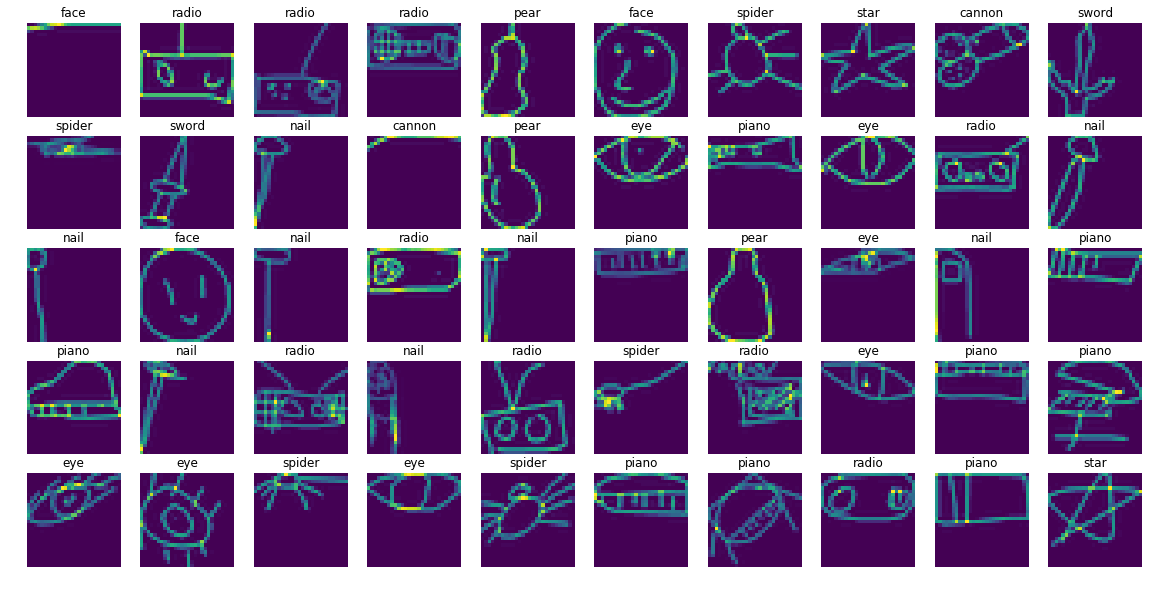

In [6]:
view_images_grid(X, y)

It is also interesting to view the "heatmaps" for images for one category. The "heatmaps" are generalized representations of images coming from one category. "Heatmaps" are created out of mean values for pixels for all images from one category:

In [7]:
def get_label_heatmap(X, y, label, label_name):
    """
    Function to plot the heatmap for images with same label.
    INPUT:
        X - (numpy array) dataset
        y - (numpy array) labels for X dataset
        label - (int) label for images
        label_name - (str) name for images label

    OUTPUT: None
    """
    # filter X_train to remove all other images
    label_filter = y == label
    X = pd.DataFrame(X)
    X_labeled = X[label_filter]

    # find mean value for pixels
    X_mean = np.sum(X_labeled, axis = 0).values

    return X_mean

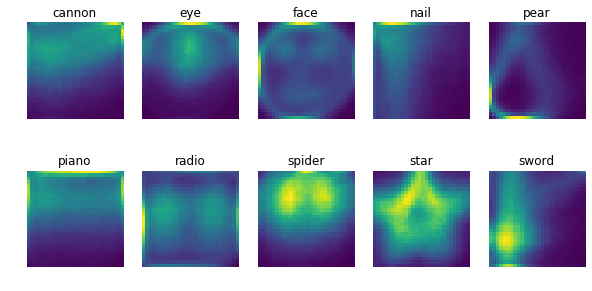

In [8]:
fig, axs = plt.subplots(2,5, figsize=(10,5))

for key, value in label_dict.items():
    # get heatmap
    heatmap = get_label_heatmap(X, y, key, value)
    
    i = key // 5
    j = key % 5
    
    # plot image
    axs[i,j].set_title(value)
    axs[i,j].imshow(heatmap.reshape(28, 28).squeeze())
    axs[i,j].axis('off')
    
plt.show()

The heatmaps demonstrated on visualizations above, in fact, represent the generalized idea of each class. Looking at the heatmaps, we can make a lot of interesting observations:
* People who play the game give the star a five-pointed representation.
* People who play the game represent nail as a metal spike (not as a body part).
* Game players generally draw the sword pointed upwards.

## MODELLING

Since there is a lot of data, and I can even generate additional data by flipping and rotating the images, I decided to use deep learning approaches to classify drawings.
<br>I started with a simple fully connected neural network with two hidden layers built with the PyTorch library.
The sizes of the layers are as follows:
* Input layer: 784 (for 28 x 28 images),
* Hidden layer 1: 128,
* Hidden layer 2: 100,
* Output layer: 10 (the number of classes).

For each hidden layer there is:
* ReLU activation function,
* Batch normalization.

The resulting model has hyperparameters as follows:
* Learning rate,
* Dropout for hidden layers,
* Weight decay (L2 regularization),
* Optimizer: Adam or SGD.

In [9]:
def build_model(input_size, output_size, hidden_sizes, dropout = 0.0):
    '''
    Function creates deep learning model based on parameters passed.

    INPUT:
        input_size, output_size, hidden_sizes - layer sizes
        dropout - dropout (probability of keeping a node)

    OUTPUT:
        model - deep learning model
    '''

    # Build a feed-forward network
    model = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                          ('relu1', nn.ReLU()),
                          ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                          ('bn2', nn.BatchNorm1d(num_features=hidden_sizes[1])),
                          ('relu2', nn.ReLU()),
                          ('dropout', nn.Dropout(dropout)),
                          ('fc3', nn.Linear(hidden_sizes[1], hidden_sizes[2])),
                          ('bn3', nn.BatchNorm1d(num_features=hidden_sizes[2])),
                          ('relu3', nn.ReLU()),
                          ('logits', nn.Linear(hidden_sizes[2], output_size))]))

    return model

def shuffle(X_train, y_train):
    """
    Function which shuffles training dataset.
    INPUT:
        X_train - (tensor) training set
        y_train - (tensor) labels for training set

    OUTPUT:
        X_train_shuffled - (tensor) shuffled training set
        y_train_shuffled - (tensor) shuffled labels for training set
    """
    X_train_shuffled = X_train.numpy()
    y_train_shuffled = y_train.numpy().reshape((X_train.shape[0], 1))

    permutation = list(np.random.permutation(X_train.shape[0]))
    X_train_shuffled = X_train_shuffled[permutation, :]
    y_train_shuffled = y_train_shuffled[permutation, :].reshape((X_train.shape[0], 1))

    X_train_shuffled = torch.from_numpy(X_train_shuffled).float()
    y_train_shuffled = torch.from_numpy(y_train_shuffled).long()

    return X_train_shuffled, y_train_shuffled

def fit_model(model, X_train, y_train, epochs = 100, n_chunks = 1000, learning_rate = 0.003, weight_decay = 0, optimizer = 'SGD'):
    """
    Function which fits the model.

    INPUT:
        model - pytorch model to fit
        X_train - (tensor) train dataset
        y_train - (tensor) train dataset labels
        epochs - number of epochs
        n_chunks - number of chunks to cplit the dataset
        learning_rate - learning rate value

    OUTPUT: None
    """

    print("Fitting model with epochs = {epochs}, learning rate = {lr}\n"\
    .format(epochs = epochs, lr = learning_rate))

    criterion = nn.CrossEntropyLoss()

    if (optimizer == 'SGD'):
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay= weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)

    print_every = 10

    steps = 0

    for e in range(epochs):
        running_loss = 0

        X_train, y_train = shuffle(X_train, y_train)

        images = torch.chunk(X_train, n_chunks)
        labels = torch.chunk(y_train, n_chunks)

        for i in range(n_chunks):
            steps += 1

            optimizer.zero_grad()

            # Forward and backward passes
            output = model.forward(images[i])
            loss = criterion(output, labels[i].squeeze())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        if epochs % print_every == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))

            running_loss = 0
                
                
def view_classify(img, ps):
    """
    Function for viewing an image and it's predicted classes
    with matplotlib.

    INPUT:
        img - (tensor) image file
        ps - (tensor) predicted probabilities for each class
    """
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(['cannon','eye', 'face', 'nail', 'pear','piano','radio','spider','star','sword'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    plt.show()
    
def test_model(model, img):
    """
    Function creates test view of the model's prediction for image.

    INPUT:
        model - pytorch model
        img - (tensor) image from the dataset

    OUTPUT: None
    """

    # Convert 2D image to 1D vector
    img = img.resize_(1, 784)

    ps = get_preds(model, img)
    view_classify(img.resize_(1, 28, 28), ps)

def get_preds(model, input):
    """
    Function to get predicted probabilities from the model for each class.

    INPUT:
        model - pytorch model
        input - (tensor) input vector

    OUTPUT:
        ps - (tensor) vector of predictions
    """

    # Turn off gradients to speed up this part
    with torch.no_grad():
        logits = model.forward(input)
    ps = F.softmax(logits, dim=1)
    return ps

def get_labels(pred):
    """
        Function to get the vector of predicted labels for the images in
        the dataset.

        INPUT:
            pred - (tensor) vector of predictions (probabilities for each class)
        OUTPUT:
            pred_labels - (numpy) array of predicted classes for each vector
    """

    pred_np = pred.numpy()
    pred_values = np.amax(pred_np, axis=1, keepdims=True)
    pred_labels = np.array([np.where(pred_np[i, :] == pred_values[i, :])[0] for i in range(pred_np.shape[0])])
    pred_labels = pred_labels.reshape(len(pred_np), 1)

    return pred_labels

def evaluate_model(model, train, y_train, test, y_test):
    """
    Function to print out train and test accuracy of the model.

    INPUT:
        model - pytorch model
        train - (tensor) train dataset
        y_train - (numpy) labels for train dataset
        test - (tensor) test dataset
        y_test - (numpy) labels for test dataset

    OUTPUT:
        accuracy_train - accuracy on train dataset
        accuracy_test - accuracy on test dataset
    """
    train_pred = get_preds(model, train)
    train_pred_labels = get_labels(train_pred)

    test_pred = get_preds(model, test)
    test_pred_labels = get_labels(test_pred)

    accuracy_train = accuracy_score(y_train, train_pred_labels)
    accuracy_test = accuracy_score(y_test, test_pred_labels)

    print("Accuracy score for train set is {} \n".format(accuracy_train))
    print("Accuracy score for test set is {} \n".format(accuracy_test))

    return accuracy_train, accuracy_test

def plot_learning_curve(input_size, output_size, hidden_sizes, train, labels, y_train, test, y_test, learning_rate = 0.003, weight_decay = 0.0, dropout = 0.0, n_chunks = 1000, optimizer = 'SGD'):
    """
    Function to plot learning curve depending on the number of epochs.

    INPUT:
        input_size, output_size, hidden_sizes - model parameters
        train - (tensor) train dataset
        labels - (tensor) labels for train dataset
        y_train - (numpy) labels for train dataset
        test - (tensor) test dataset
        y_test - (numpy) labels for test dataset
        learning_rate - learning rate hyperparameter
        weight_decay - weight decay (regularization)
        dropout - dropout for hidden layer
        n_chunks - the number of minibatches to train the model
        optimizer - optimizer to be used for training (SGD or Adam)

    OUTPUT: None
    """
    train_acc = []
    test_acc = []

    for epochs in np.arange(10, 60, 10):
        # create model
        model = build_model(input_size, output_size, hidden_sizes, dropout = dropout)

        # fit model
        fit_model(model, train, labels, epochs = epochs, n_chunks = n_chunks, learning_rate = learning_rate, weight_decay = weight_decay, optimizer = 'SGD')
        # get accuracy
        accuracy_train, accuracy_test = evaluate_model(model, train, y_train, test, y_test)

        train_acc.append(accuracy_train)
        test_acc.append(accuracy_test)
    
    return train_acc, test_acc

Let's try out the model:

In [10]:
# Split dataset into train/test splits
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

In [14]:
# Convert to tensors
train = torch.from_numpy(X_train).float()
labels = torch.from_numpy(y_train).long()
test = torch.from_numpy(X_test).float()
test_labels = torch.from_numpy(y_test).long()

# Set hyperparameters for our network
input_size = 784
hidden_sizes = [128, 100, 64]
output_size = 10

dropout = 0.0
weight_decay = 0.0
n_chunks = 700
learning_rate = 0.03
optimizer = 'SGD'

In [15]:
# Build model
model = build_model(input_size, output_size, hidden_sizes, dropout = dropout)

# Fit model
train_acc, test_acc = plot_learning_curve(input_size, output_size, hidden_sizes, train, labels, y_train, test, y_test, learning_rate = learning_rate, dropout = dropout, weight_decay = weight_decay, n_chunks = n_chunks, optimizer = optimizer)

Fitting model with epochs = 10, learning rate = 0.03

Epoch: 1/10...  Loss: 84.8703
Epoch: 2/10...  Loss: 56.4065
Epoch: 3/10...  Loss: 48.7383
Epoch: 4/10...  Loss: 43.2959
Epoch: 5/10...  Loss: 38.9596
Epoch: 6/10...  Loss: 35.6102
Epoch: 7/10...  Loss: 32.2861
Epoch: 8/10...  Loss: 29.1549
Epoch: 9/10...  Loss: 26.3767
Epoch: 10/10...  Loss: 24.3731
Accuracy score for train set is 0.9347142857142857 

Accuracy score for test set is 0.787 

Fitting model with epochs = 20, learning rate = 0.03

Epoch: 1/20...  Loss: 85.6614
Epoch: 2/20...  Loss: 56.8123
Epoch: 3/20...  Loss: 48.8489
Epoch: 4/20...  Loss: 43.4952
Epoch: 5/20...  Loss: 39.2700
Epoch: 6/20...  Loss: 35.5530
Epoch: 7/20...  Loss: 32.7583
Epoch: 8/20...  Loss: 29.6239
Epoch: 9/20...  Loss: 27.3271
Epoch: 10/20...  Loss: 24.4448
Epoch: 11/20...  Loss: 22.3826
Epoch: 12/20...  Loss: 20.6359
Epoch: 13/20...  Loss: 18.4333
Epoch: 14/20...  Loss: 17.2650
Epoch: 15/20...  Loss: 15.9475
Epoch: 16/20...  Loss: 14.2731
Epoch: 17/20

Let's plot the accuracy with respect to the number of epochs:

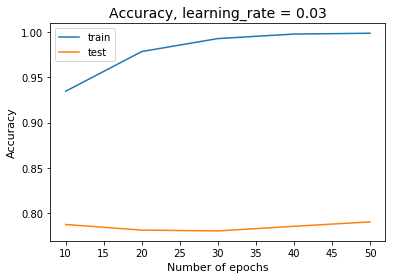

In [16]:
# Plot curve
x = np.arange(10, 10 * (len(train_acc) + 1), 10)
plt.plot(x, train_acc)
plt.plot(x, test_acc)
plt.legend(['train', 'test'], loc='upper left')
plt.title('Accuracy, learning_rate = ' + str(learning_rate), fontsize=14)
plt.xlabel('Number of epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.show()

Looking at the plot above we can say that we have model variance problem. On the training set we achieved 99% accuracy, which means that we fitted the training set quite well. But there is also a huge gap between training and test accuracy, which means that there is a variance problem, and we actually overfitted for the training dataset and fail to predict on the test set.
<br>Variance problem can be addressed by increasing the training set. We have two options: get more images from the original dataset or generate more images from existing ones by flipping and rotating.
<br>I will try the second option just to demonstrate how generation more data out of the existing works.

In [17]:
def convert_to_PIL_from_np(img):
    """
    Function to convert numpy (1, 784) image to PIL image.
    INPUT:
        img - (numpy array) image from train dataset with size (1, 784)
    OUTPUT:
        pil_img - (PIL Image) 28x28 image
    """
    img_r = img.reshape(28,28)

    pil_img = Image.new('RGB', (28, 28), 'white')
    pixels = pil_img.load()

    for i in range(0, 28):
        for j in range(0, 28):
            if img_r[i, j] > 0:
                pixels[j, i] = (255 - int(img_r[i, j] * 255), 255 - int(img_r[i, j] * 255), 255 - int(img_r[i, j] * 255))

    return pil_img

def add_flipped_and_rotated_images(X_train, y_train):
    """
    Function which adds flipped and rotated images to the original dataset.
    INPUT:
        X_train - (numpy array) the original training set
        y_train - (numpy array) original labels dataset
    OUTPUT:
        X_Train_new - (numpy array) the dataset with added flipped and rotated
        images
        y_train_new - (numpy array) labels for the new training dataset
    """
    print("Adding flipped and rotated images to the training set. \n")

    X_train_new = X_train.copy()
    y_train_new = y_train.copy().reshape(y_train.shape[0], 1)

    for i in range(0, X_train.shape[0], 10): # I will skip some images just to run this faster 
        # get image to rotate and flip
        img = X_train[i]
        pil_img = convert_to_PIL_from_np(img)

        # get random angle
        angle = random.randint(5, 10)

        # rotate and flip
        rotated = convert_to_np(rotate_image(pil_img, angle), 28, 28)
        flipped = convert_to_np(flip_image(pil_img), 28, 28)

        # add to the original dataset
        X_train_new = np.append(X_train_new, rotated.reshape(1, 784), axis = 0)
        X_train_new = np.append(X_train_new, flipped.reshape(1, 784), axis = 0)
        y_train_new = np.append(y_train_new, y_train[i].reshape(1,1), axis = 0)
        y_train_new = np.append(y_train_new, y_train[i].reshape(1,1), axis = 0)

        # print out progress
        if i % 1000 == 0:
            print("Processed {i} files out of {total}.".format(i= i, total = X_train.shape[0]))

    return X_train_new, y_train_new

I will demonstrate example of flipped and rotated images:

(-0.5, 27.5, 27.5, -0.5)

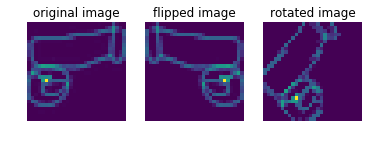

In [18]:
# examples of flipped and rotated images
fig, axs = plt.subplots(1,3, figsize=(6,3))

np_img = X[0]
np_img_flipped = convert_to_np(flip_image(convert_to_PIL_from_np(np_img)), 28, 28)
np_img_rotated = convert_to_np(rotate_image(convert_to_PIL_from_np(np_img)), 28, 28)

# plot the original image
axs[0].set_title('original image')
axs[0].imshow(np_img.reshape(28, 28).squeeze())
axs[0].axis('off')

# plot the flipped image
axs[1].set_title('flipped image')
axs[1].imshow(np_img_flipped.reshape(28, 28).squeeze())
axs[1].axis('off')

# plot the rotated image
axs[2].set_title('rotated image')
axs[2].imshow(np_img_rotated.reshape(28, 28).squeeze())
axs[2].axis('off')

In [19]:
X_train, y_train = add_flipped_and_rotated_images(X_train, y_train)

Adding flipped and rotated images to the training set. 

Processed 0 files out of 21000.
Processed 1000 files out of 21000.
Processed 2000 files out of 21000.
Processed 3000 files out of 21000.
Processed 4000 files out of 21000.
Processed 5000 files out of 21000.
Processed 6000 files out of 21000.
Processed 7000 files out of 21000.
Processed 8000 files out of 21000.
Processed 9000 files out of 21000.
Processed 10000 files out of 21000.
Processed 11000 files out of 21000.
Processed 12000 files out of 21000.
Processed 13000 files out of 21000.
Processed 14000 files out of 21000.
Processed 15000 files out of 21000.
Processed 16000 files out of 21000.
Processed 17000 files out of 21000.
Processed 18000 files out of 21000.
Processed 19000 files out of 21000.
Processed 20000 files out of 21000.


Let's try to fit the model using new dataset with generated images:

In [20]:
train = torch.from_numpy(X_train).float()
labels = torch.from_numpy(y_train).long()

# Fit model
train_acc, test_acc = plot_learning_curve(input_size, output_size, hidden_sizes, train, labels, y_train, test, y_test, learning_rate = learning_rate, dropout = dropout, weight_decay = weight_decay, n_chunks = 400, optimizer = optimizer)

Fitting model with epochs = 10, learning rate = 0.03

Epoch: 1/10...  Loss: 57.0027
Epoch: 2/10...  Loss: 34.9338
Epoch: 3/10...  Loss: 28.9488
Epoch: 4/10...  Loss: 25.6552
Epoch: 5/10...  Loss: 22.8640
Epoch: 6/10...  Loss: 20.4858
Epoch: 7/10...  Loss: 18.4331
Epoch: 8/10...  Loss: 16.4242
Epoch: 9/10...  Loss: 14.6638
Epoch: 10/10...  Loss: 13.3762
Accuracy score for train set is 0.9317460317460318 

Accuracy score for test set is 0.7873333333333333 

Fitting model with epochs = 20, learning rate = 0.03

Epoch: 1/20...  Loss: 55.3013
Epoch: 2/20...  Loss: 34.6174
Epoch: 3/20...  Loss: 28.5719
Epoch: 4/20...  Loss: 25.2271
Epoch: 5/20...  Loss: 22.5080
Epoch: 6/20...  Loss: 20.2876
Epoch: 7/20...  Loss: 18.0582
Epoch: 8/20...  Loss: 16.4023
Epoch: 9/20...  Loss: 15.0036
Epoch: 10/20...  Loss: 13.4893
Epoch: 11/20...  Loss: 12.0587
Epoch: 12/20...  Loss: 10.6883
Epoch: 13/20...  Loss: 9.7426
Epoch: 14/20...  Loss: 8.8166
Epoch: 15/20...  Loss: 7.9992
Epoch: 16/20...  Loss: 7.1888
Epo

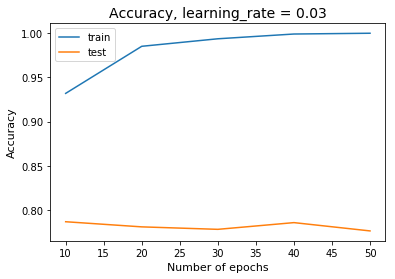

In [21]:
# Plot curve
x = np.arange(10, 10 * (len(train_acc) + 1), 10)
plt.plot(x, train_acc)
plt.plot(x, test_acc)
plt.legend(['train', 'test'], loc='upper left')
plt.title('Accuracy, learning_rate = ' + str(learning_rate), fontsize=14)
plt.xlabel('Number of epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.show()

The plot above shows us that even adding generated data can help to reduce bias and variance.

I still see huge gap between train and test accuracy scores. It means that we have to implement some regularizations techniques to reduce the variance. In current case it turns out that L2 regularization (weight decay) doesn't work out. But adding dropout to each hidden layer will help a little. I also added Adam optimizer to speed up the calculations.

In [22]:
# Fit model
train_acc, test_acc = plot_learning_curve(input_size, output_size, hidden_sizes, train, labels, y_train, test, y_test, learning_rate = learning_rate, dropout = 0.2, weight_decay = weight_decay, n_chunks = 400, \
                                          optimizer = 'Adam')

Fitting model with epochs = 10, learning rate = 0.03

Epoch: 1/10...  Loss: 58.4843
Epoch: 2/10...  Loss: 38.3502
Epoch: 3/10...  Loss: 32.7945
Epoch: 4/10...  Loss: 29.1901
Epoch: 5/10...  Loss: 26.7329
Epoch: 6/10...  Loss: 24.9017
Epoch: 7/10...  Loss: 22.8454
Epoch: 8/10...  Loss: 21.4652
Epoch: 9/10...  Loss: 19.8019
Epoch: 10/10...  Loss: 18.3294
Accuracy score for train set is 0.8884126984126984 

Accuracy score for test set is 0.7767777777777778 

Fitting model with epochs = 20, learning rate = 0.03

Epoch: 1/20...  Loss: 58.1969
Epoch: 2/20...  Loss: 38.6106
Epoch: 3/20...  Loss: 32.8852
Epoch: 4/20...  Loss: 29.7066
Epoch: 5/20...  Loss: 27.1662
Epoch: 6/20...  Loss: 25.1468
Epoch: 7/20...  Loss: 23.2873
Epoch: 8/20...  Loss: 21.4434
Epoch: 9/20...  Loss: 20.5872
Epoch: 10/20...  Loss: 18.7321
Epoch: 11/20...  Loss: 17.6253
Epoch: 12/20...  Loss: 16.4780
Epoch: 13/20...  Loss: 15.1763
Epoch: 14/20...  Loss: 14.2951
Epoch: 15/20...  Loss: 13.2435
Epoch: 16/20...  Loss: 12.4960

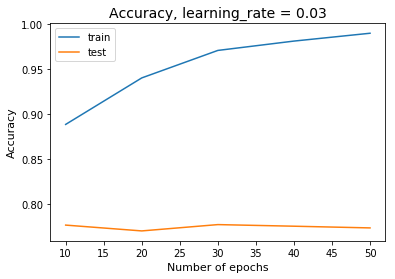

In [23]:
# Plot curve
x = np.arange(10, 10 * (len(train_acc) + 1), 10)
plt.plot(x, train_acc)
plt.plot(x, test_acc)
plt.legend(['train', 'test'], loc='upper left')
plt.title('Accuracy, learning_rate = ' + str(learning_rate), fontsize=14)
plt.xlabel('Number of epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.show()

We see that introducing dropout to the model actually helped to reduce the gap between train and test accuracy scores. But we still have to work on the regularization of the model, because we have poor test accuracy. The easiest thing, which I didn't do in this tutorial (to reduce the computation time) is to add more data to the training set (images from the original dataset or some generated data), and to make more training epochs.

The example of the output from the resulting model:

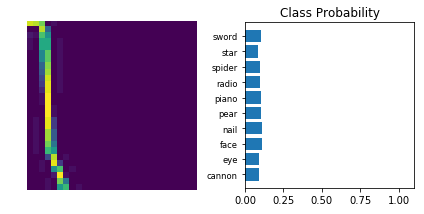

In [44]:
# turn off batch normalization
model.eval()

# get prediction for the image from the test dataset
test_model(model, test[45])

## CONCLUSION

In this kernel I demonstrated an example how to build simple fully connected neural network to classify simple images. While building the solution we used the original data and artificially generated data and introduced regularization techniques such as dropout to reduce variance of the model. The final model has the accuracy about 80% (this can be improved by adding more data and using more epochs while training, I didn't do that to reduce the running time of the kernel).

### Improvement
The model performs quite well on ten image classes from the simplified dataset, but there is a lot to improve:
* Add more drawing classes;
* Try other architectures, such as convolutional neural networks;
* Try the full dataset, which contains images with higher resolution and additional information (country, strokes and so on).